In [1210]:
import pandas as pd 
import numpy as np 
from collections import Counter
import xgboost
import os
import time
import warnings
import sklearn
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score
import datetime
%matplotlib inline
warnings.filterwarnings('ignore')

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001D1D7D22B00>>
Traceback (most recent call last):
  File "c:\users\lance\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001D1D7D2A710>>
Traceback (most recent call last):
  File "c:\users\lance\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001D1D7D2EC50>>
Traceback (most recent call last):
  File "c:\users\lance\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py", line 324, in __del_

In [1211]:
file=r'c:/users/lance/desktop/GitHub_project/tianchi_power_data/matrix_0.csv'
weatherfile=r'c:/users/lance/desktop/GitHub_project/tianchi_power_data/weather_data_2014-1-1~2016~9-30.xlsx'
holidayfile=r'c:/users/lance/desktop/GitHub_project/tianchi_power_data/holidays.xlsx'
numst='sum'

In [1212]:
data=pd.read_csv(file)
weatherdata=pd.read_excel(weatherfile)
holidaydata=pd.read_excel(holidayfile,header=None)
data=data.set_index('Unnamed: 0')
k=[str(x) for x in range(1,1455)]
k.append('sum')
data.columns=k
weatherdata=weatherdata.set_index('date')



def tz(df,str1):
    df['timestamp']=df.index
    df['time_stamp']=pd.DataFrame(pd.to_datetime(df['timestamp']))
    df['dow'] = df.time_stamp.apply(lambda x: x.dayofweek)
    df['doy'] = df.time_stamp.apply(lambda x: x.dayofyear)
    df['day'] = df.time_stamp.apply(lambda x: x.day)
    df['is_weekend']=df.time_stamp.apply(lambda x:1 if x.dayofweek in range(5,7) else 0)
    df['month'] = df.time_stamp.apply(lambda x: x.month)
    df['d-1']=df[str1].shift(1)
    df['d-2']=df[str1].shift(2)
    df['d_dif']=df['d-1']-df['d-2']
    weatherdata['date']=weatherdata.index
    combineddf=pd.merge(left=df,right=weatherdata,left_on='time_stamp',right_on='date',how='left')
    combineddf=combineddf.fillna(1)
    return combineddf

combineddf=tz(pd.DataFrame(data[numst]),numst)
combineddf=combineddf.set_index('time_stamp')

In [1213]:
holidaylist=list(holidaydata[0])
combineddf['is_holiday']=combineddf.timestamp.apply(lambda x:1 if pd.to_datetime(x) in holidaylist else 0)

In [1214]:
# data=data.reset_index()

# data['num_working']=1454
# for i in range(0,609):
#     data.loc[i,'num_working']=1454-Counter(data.loc[i,][1:1455])[1]

# combineddf=pd.concat([combineddf.reset_index(),pd.DataFrame(data.num_working)],axis=1)

In [1215]:
X=combineddf[['dow','doy','day','month','d-1','d-2','d_dif',
              'max','min',
              'max-min','is_holiday','is_weekend']]
Y=combineddf[[numst]]

Xtrain=X[X.index<'2016-08-01']
Ytrain=Y[Y.index<'2016-08-01']

Xtest=X[(X.index>='2016-08-01')&(X.index<'2016-09-01')]
Ytest=Y[(Y.index>='2016-08-01')&(Y.index<'2016-09-01')]

#rfr=xgboost.sklearn.XGBRegressor()
rfr=GradientBoostingRegressor(max_depth=6,n_estimators=150,verbose=1,learning_rate=0.091,
                               random_state=1,warm_start=True,min_samples_split=4,min_samples_leaf=2)

In [1216]:
rfr.fit(Xtrain,Ytrain)
print(rfr.score(Xtrain,Ytrain))

result=pd.read_excel(r'c:/users/lance/desktop/GitHub_project/tianchi_power_data/result.xlsx')

result['dow'] = result.date.apply(lambda x: x.dayofweek)
result['doy'] = result.date.apply(lambda x: x.dayofyear)
result['day'] = result.date.apply(lambda x: x.day)
result['month'] = result.date.apply(lambda x: x.month)
result['is_holiday']=result.date.apply(lambda x:1 if pd.to_datetime(x) in holidaylist else 0)
result['is_weekend']=result.date.apply(lambda x:1 if pd.to_datetime(x).dayofweek in range(5,7) else 0)


combinedresultdf=pd.merge(left=result,right=weatherdata,left_on='date',right_on='date',how='left')

combinedresultdf=combinedresultdf[['date','dow','doy','day','month',
                                   'max','min',
                                   'max-min','is_holiday','is_weekend']]

combinedresultdf['d-1']=0
combinedresultdf['d-2']=0
combinedresultdf['d_dif']=0

combinedresultdf=combinedresultdf.set_index('date')
combinedresultdf.head()
c2=combinedresultdf

c2=c2.reset_index()


c2.loc[1,'d_dif']=c2.loc[1,'d-1']-c2.loc[1,'d-2']


namelist=['dow','doy','day','month','d-1','d-2','d_dif',
          'max','min',
          'max-min','is_holiday','is_weekend']

      Iter       Train Loss   Remaining Time 
         1 200159654954.9075            0.82s
         2 170450115567.7575            0.74s
         3 146105286655.8961            0.69s
         4 125946935388.0540            0.69s
         5 108794350198.8874            0.68s
         6 94263239531.3321            0.68s
         7 82330234602.2258            0.67s
         8 72265691308.3560            0.66s
         9 63393187261.1936            0.64s
        10 56068430082.3853            0.64s
        20 22389310724.8066            0.51s
        30 13551078679.4194            0.46s
        40  9293352335.1990            0.44s
        50  6695713997.6383            0.38s
        60  5085817634.8574            0.33s
        70  3950451498.7278            0.28s
        80  2968717843.3173            0.24s
        90  2351371022.7274            0.22s
       100  1845501107.4024            0.18s
0.997413836669


In [1217]:
c2.loc[0,'d-1']=Y.loc['2016-07-31'][0]
c2.loc[0,'d-2']=Y.loc['2016-07-30'][0]
c2.loc[0,'d_dif']=c2.loc[0,'d-1']-c2.loc[0,'d-2']
c2.loc[1,'d-2']=Y.loc['2016-07-31'][0]
c2.head()

,date,dow,doy,day,month,max,min,max-min,is_holiday,is_weekend,d-1,d-2,d_dif
0,2016-08-01,0,214,1,8,35,27,8,0,0,4259280,4514944,-255664
1,2016-08-02,1,215,2,8,35,27,8,0,0,0,4259280,0
2,2016-08-03,2,216,3,8,32,25,7,0,0,0,0,0
3,2016-08-04,3,217,4,8,33,26,7,0,0,0,0,0
4,2016-08-05,4,218,5,8,33,26,7,0,0,0,0,0


In [1219]:
for x in range(61):
    if x!=60:
        a=rfr.predict(pd.DataFrame(c2.loc[x,namelist]).T)[0]
        c2.loc[x+1,'d-1']=a
        c2.loc[x+2,'d-2']=a
        c2.loc[x,'d_dif']=c2.loc[x,'d-1']-c2.loc[x,'d-2']
        c2.loc[x,'pre']=a
    elif x==60:
        a=rfr.predict(pd.DataFrame(c2.loc[x,namelist]).T)[0]
        c2.loc[x,'pre']=a
        c2.loc[x,'d_dif']=c2.loc[x,'d-1']-c2.loc[x,'d-2']

c2=c2[c2.index<61]
c2

,date,dow,doy,day,month,max,min,max-min,is_holiday,is_weekend,d-1,d-2,d_dif,pre
0,2016-08-01,0.0,214.0,1.0,8.0,35.0,27.0,8.0,0.0,0.0,4.259280e+06,4.514944e+06,-255664.000000,4.252516e+06
1,2016-08-02,1.0,215.0,2.0,8.0,35.0,27.0,8.0,0.0,0.0,4.252516e+06,4.259280e+06,-6764.043063,4.279195e+06
2,2016-08-03,2.0,216.0,3.0,8.0,32.0,25.0,7.0,0.0,0.0,4.279195e+06,4.252516e+06,26679.039682,4.240875e+06
3,2016-08-04,3.0,217.0,4.0,8.0,33.0,26.0,7.0,0.0,0.0,4.240875e+06,4.279195e+06,-38319.689690,4.298129e+06
4,2016-08-05,4.0,218.0,5.0,8.0,33.0,26.0,7.0,0.0,0.0,4.298129e+06,4.240875e+06,57253.842135,4.293871e+06
5,2016-08-06,5.0,219.0,6.0,8.0,33.0,26.0,7.0,0.0,1.0,4.293871e+06,4.298129e+06,-4258.067432,4.051732e+06
6,2016-08-07,6.0,220.0,7.0,8.0,34.0,26.0,8.0,0.0,1.0,4.051732e+06,4.293871e+06,-242139.333856,3.757738e+06
7,2016-08-08,0.0,221.0,8.0,8.0,35.0,26.0,9.0,0.0,0.0,3.757738e+06,4.051732e+06,-293994.216215,4.180604e+06
8,2016-08-09,1.0,222.0,9.0,8.0,34.0,27.0,7.0,0.0,0.0,4.180604e+06,3.757738e+06,422866.067432,4.228401e+06
9,2016-08-10,2.0,223.0,10.0,8.0,33.0,27.0,6.0,0.0,0.0,4.228401e+06,4.180604e+06,47797.317100,4.272131e+06


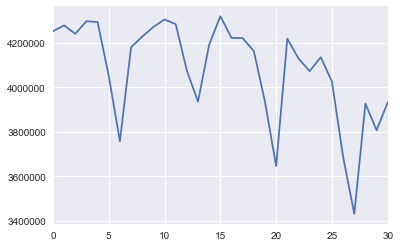

In [1220]:
c2['pre'][:31].plot()

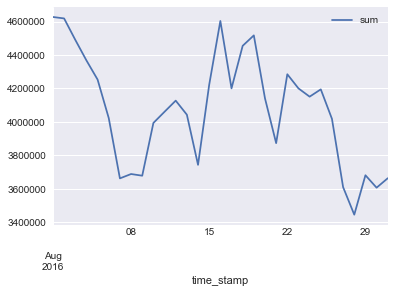

In [1221]:
Ytest.plot()

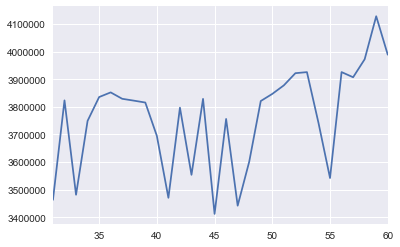

In [1222]:
c2['pre'][31:].plot()

In [1223]:
r2_score(y_pred=c2['pre'][:31],y_true=Ytest)

0.52432159140983692

In [1224]:
filename=r'c:/users/lance/desktop/GitHub_project/tianchi_power_data/'+numst+r'.xlsx'
print(filename)
c2[['date','pre']].to_excel(filename)

c:/users/lance/desktop/GitHub_project/tianchi_power_data/sum.xlsx


In [1228]:
import seaborn as sns

ValueError: cannot label index with a null key

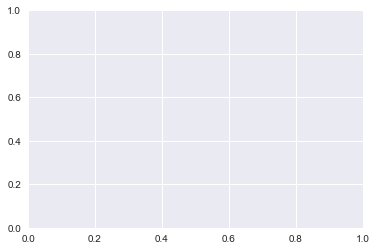

In [1227]:

combineddf.head()

,sum,timestamp,dow,doy,day,is_weekend,month,d-1,d-2,d_dif,max,min,weather,wind,wind_speed,max-min,date,is_holiday
time_stamp,,,,,,,,,,,,,,,,,,
2015-01-01,2900575,2015/1/1,3,1,1,0,1,1.0,1.0,1.0,8.0,-4.0,晴,西南风,小于3级,12.0,2015-01-01,1
2015-01-02,3158211,2015/1/2,4,2,2,0,1,2900575.0,1.0,1.0,13.0,0.0,多云转晴,东南风,小于3级,13.0,2015-01-02,1
2015-01-03,3596487,2015/1/3,5,3,3,1,1,3158211.0,2900575.0,257636.0,16.0,3.0,多云,南风,小于3级,13.0,2015-01-03,1
2015-01-04,3939672,2015/1/4,6,4,4,1,1,3596487.0,3158211.0,438276.0,15.0,4.0,晴转阴,东风,3-4级,11.0,2015-01-04,0
2015-01-05,4101790,2015/1/5,0,5,5,0,1,3939672.0,3596487.0,343185.0,10.0,2.0,小雨转雨夹雪,西北风,4-5级转3-4级,8.0,2015-01-05,0
